# Workflow 1 - extract features from the trajectory

**Input:** reference PDB and trajectory


**Output:** featurized trajectory
<hr>
Steps:

1. Load reference PDB and trajectory in the EnGen object
3. Provide set of featurizations of interest (or use default)
4. Evaluate different featurization (optional)
5. Choose the best featurization
6. Extract those features

In [17]:
# required imports 
from engens.core.EnGens import EnGen
import engens.core.FeatureSelector as fs
import pickle
import mdshare
import mdtraj

### Step 1 - load the structure and trajectory

Provide the path to the files with the reference trajectory and topology.
(You can use any format that <a fref = https://mdtraj.org/1.9.4/api/generated/mdtraj.load.html> mdtraj.load </a> will take as input).

Optionally, provide a subset of the structure that you will use for featurization (e.g. binding site) as a <a href=https://mdtraj.org/1.9.4/atom_selection.html> atom selection string </a> or a list of atom indices.


In [2]:
# If you do not have trajectories of your own you can fetch this pentapeptide example 
# or any other example from mdshare platform: https://markovmodel.github.io/mdshare/

pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='.')
files = mdshare.fetch('pentapeptide-00-500ns-impl-solv.xtc', working_directory='.')

In [3]:
# Location of trajectory and topology files
# (you can specify your own files here)
top_loc = "./pentapeptide-impl-solv.pdb"
traj_loc = "./pentapeptide-00-500ns-impl-solv.xtc"

#Instrantiate the engens object

#------------------------three options----------------------------#
#-----you can uncomment any option that you would like to try-----#

#Option 1 - load the full trajectory as a EnGen object 
'''
#load full trajectory
engen = EnGen(traj_loc, top_loc)
'''

#Option 2 - load a part of the trajectory by specifying a list of atoms of interest (binding site)
#for example - first 10 atoms of the structure
'''
#load first 10 atoms of the trajectory
N = 10
select_list = [i for i in range(N)]
engen = EnGen(traj_loc, top_loc, select_list)
'''

#Option 3 - load a part of the trajectory by specifying a selection string (binding site)
#using atom selection format https://mdtraj.org/1.9.4/atom_selection.html
#for example - you can specify residues with id 1, 2, 3 
'''
#load residues 1,2,3 of the trajectory
binding_site_selstr = "resid 1 or resid 2 or resid 3"
engen = EnGen(traj_loc, top_loc, binding_site_selstr)
'''

#------------------------end of options----------------------------#

#visualize the trajectory (optional - if trajectory too large, skip this step)
nglwidget = engen.show_animated_traj()

nglwidget

NGLWidget(max_frame=5000)

### Step 2 - select different featurizations

Here we select ways to featurize the trajectory. Any PyEmma <a href = http://www.emma-project.org/latest/api/generated/pyemma.coordinates.featurizer.html> trajectory featurization </a> can be used in this step and any of the parameters of the respective featurizations can be provided. Users can also use the default initialization which includes three sets of features: (1) amino-acid pairwise distances; (2) torsion angles and (3) amino-acid pairwise distances with the torsion angels.

In [4]:
# Select the featurization for EnGens
# (this step is performed on the selection you loaded above)

#------------------------two options----------------------------#
#-----you can uncomment any option that you would like to try-----#

# Option 1 - extract the default features 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# in this case the three default featurizations  will be added to engen object: 
# (1) aadist, (2) tangle and (3) aadist&tangle
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

'''
# remove any existing featurizers
engen.reset_featurizers()

# initialize default features 
engen.init_featurizers_default()
'''

# Option 2 - define the features you want to add on your own 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# using any of the available featurizationswith PyEmma 
# http://www.emma-project.org/latest/api/generated/pyemma.coordinates.featurizer.html
# with coresponding parameters
# in this example we add three featurizations to the engen object: 
# (1) all-atoms, (2) C-alpha distances, (3) center-of-mass (COM) & tangles
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

'''
# remove any existing featurizers
engen.reset_featurizers()

#all-atoms
feat1 = {
    "add_all": {}
}
#add the respective features to the engen structure
engen.add_featurizer(feat1)

#C-alpha distances
feat2 = {
    "add_distances_ca": {"periodic":True, "excluded_neighbors":0}
}
#add the respective features to the engen structure
engen.add_featurizer(feat2)

#center of mass and torsion angles
feat3 = {
    "add_residue_COM": {"residue_indices": [1,2,3]},
    "add_backbone_torsions": {"cossin":True, "periodic":False}
}
#add the respective features to the engen structure
engen.add_featurizer(feat3)
'''

#------------------------end of options----------------------------#

# print the desctiption of the default features
description = engen.describe_featurizers()
print(description)

Featurizer no. 0:
 all
['ATOM:TRP 1 N 0 x', 'ATOM:TRP 1 N 0 y', 'ATOM:TRP 1 N 0 z', 'ATOM:TRP 1 H 1 x', 'ATOM:TRP 1 H 1 y', 'ATOM:TRP 1 H 1 z', 'ATOM:TRP 1 H2 2 x', 'ATOM:TRP 1 H2 2 y', 'ATOM:TRP 1 H2 2 z', 'ATOM:TRP 1 CA 3 x']...['ATOM:LEU 5 C 90 z', 'ATOM:LEU 5 O 91 x', 'ATOM:LEU 5 O 91 y', 'ATOM:LEU 5 O 91 z', 'ATOM:LEU 5 OXT 92 x', 'ATOM:LEU 5 OXT 92 y', 'ATOM:LEU 5 OXT 92 z', 'ATOM:LEU 5 H2 93 x', 'ATOM:LEU 5 H2 93 y', 'ATOM:LEU 5 H2 93 z']
 Featurizer no. 1:
 distances_ca
['DIST: TRP 1 CA 3 - LEU 2 CA 27', 'DIST: TRP 1 CA 3 - ALA 3 CA 46', 'DIST: TRP 1 CA 3 - LEU 4 CA 56', 'DIST: TRP 1 CA 3 - LEU 5 CA 75', 'DIST: LEU 2 CA 27 - ALA 3 CA 46', 'DIST: LEU 2 CA 27 - LEU 4 CA 56', 'DIST: LEU 2 CA 27 - LEU 5 CA 75', 'DIST: ALA 3 CA 46 - LEU 4 CA 56', 'DIST: ALA 3 CA 46 - LEU 5 CA 75', 'DIST: LEU 4 CA 56 - LEU 5 CA 75']...['DIST: TRP 1 CA 3 - LEU 2 CA 27', 'DIST: TRP 1 CA 3 - ALA 3 CA 46', 'DIST: TRP 1 CA 3 - LEU 4 CA 56', 'DIST: TRP 1 CA 3 - LEU 5 CA 75', 'DIST: LEU 2 CA 27 - ALA 3 CA 4

### Step 3 - evaluate the featurizations

This step is optional - we recommend evaluating the featurizations and picking the best using PyEmma's implementation of <a href=http://www.emma-project.org/latest/tutorials/notebooks/00-pentapeptide-showcase.html#Feature-selection> VAMP approach </a>.

This helps you choose a set of features with which to proceed to the next Workflow.

Choosing features with VAMP might take some time...
Running VAMP with different parameters. Might take some time.
dimension =2, lag=1
dimension =2, lag=25
dimension =2, lag=50
dimension =3, lag=1
dimension =3, lag=25
dimension =3, lag=50


/usr/local/lib/python3.6/site-packages/engens/core/FeatureSelector.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(names, rotation=30)


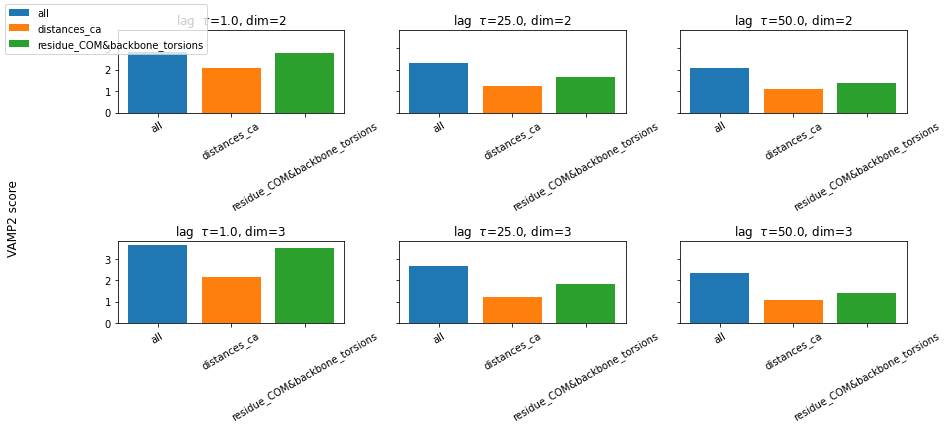

In [18]:

#provide a range of lags and dimensions to train on

#to make an informed decision on lag times see the timescale of your simulation
traj_times = mdtraj.load(engen.traj, top=engen.ref).time
#number of frames
traj_nframes = len(traj_times)
lags = [int(np.log(i)) for i in np.logspace(1, int(traj_nframes/100), num=3, base=np.e)]
dims = [i + 1 for i in range(1,3)]

#initialize VAMP2 featurizer and run it
featsel = fs.VAMP2FeatureSelection(lags, dims, engen)
featsel.run_vamp()

#plot VAMP2 results
featsel.plot_results()

### Step 4 - pick the featurization

We suggest using the featurization which gives you the highest VAMP2 score from the analysis above. To do so, run the cell below.

In [15]:
# Select using the VAMP2 selector from above 

featsel.select_feature()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# alternatively you can chose any feature regardless of the VAMP2 score by running the code commented here

'''
#print possible features
print(engen.describe_featurizers())
#select the number of the desired feature
feat_num = 1
# initialize selector
featsel = fs.UserFeatureSelection(feat_num, engen)
#select the feature
featsel.select_feature()
'''
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
print()

Choosing features with VAMP might take some time...
Using recycled VAMP2 scores.
Picked featurized no. 0: all
With maximum VAMP2 score no. 0
['ATOM:TRP 1 N 0 x', 'ATOM:TRP 1 N 0 y', 'ATOM:TRP 1 N 0 z', 'ATOM:TRP 1 H 1 x', 'ATOM:TRP 1 H 1 y', 'ATOM:TRP 1 H 1 z', 'ATOM:TRP 1 H2 2 x', 'ATOM:TRP 1 H2 2 y', 'ATOM:TRP 1 H2 2 z', 'ATOM:TRP 1 CA 3 x', 'ATOM:TRP 1 CA 3 y', 'ATOM:TRP 1 CA 3 z', 'ATOM:TRP 1 HA 4 x', 'ATOM:TRP 1 HA 4 y', 'ATOM:TRP 1 HA 4 z', 'ATOM:TRP 1 CB 5 x', 'ATOM:TRP 1 CB 5 y', 'ATOM:TRP 1 CB 5 z', 'ATOM:TRP 1 HB3 6 x', 'ATOM:TRP 1 HB3 6 y', 'ATOM:TRP 1 HB3 6 z', 'ATOM:TRP 1 HB2 7 x', 'ATOM:TRP 1 HB2 7 y', 'ATOM:TRP 1 HB2 7 z', 'ATOM:TRP 1 CG 8 x', 'ATOM:TRP 1 CG 8 y', 'ATOM:TRP 1 CG 8 z', 'ATOM:TRP 1 CD1 9 x', 'ATOM:TRP 1 CD1 9 y', 'ATOM:TRP 1 CD1 9 z', 'ATOM:TRP 1 HD1 10 x', 'ATOM:TRP 1 HD1 10 y', 'ATOM:TRP 1 HD1 10 z', 'ATOM:TRP 1 NE1 11 x', 'ATOM:TRP 1 NE1 11 y', 'ATOM:TRP 1 NE1 11 z', 'ATOM:TRP 1 HE1 12 x', 'ATOM:TRP 1 HE1 12 y', 'ATOM:TRP 1 HE1 12 z', 'ATOM:TRP 1 CE2 13

### Step 5 - save the results as input for Workflow2 - dimensionality reduction

In [16]:
# save the results for next workflow

with open("wf1_resulting_EnGen.pickle", "wb") as file:
    pickle.dump(engen, file, -1)